# 비지도학습 군집분석: 정답지가 없는 분석

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib

In [2]:
data = pd.read_csv("./data/shopping-data.csv")
data

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Genre                   200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


# 군집분석(계층적 군집, 비계층적 군집)
* 계층적 군집
  * 비지도학습
  * 데이터가 적을 때 사용(5000개 이하)
  * 거리 계산 지표: 유클리드, 맨하탄, 코사인 유사도
* 계층적 군집 5가지
  * 단일연결법(single linkage), 최단연결법: 군집과 군집 사이에서 가장 가까운 데이터를 기준으로 묶음
  * 완전연결법(complete linkage), 최장연결법: 군집과 군집 사이에서 가장 먼 데이터를 기준으로 묶음
  * 평균연결법(average linkage): 군집과 군집 사이의 모든 데이터의 평균 데이터로 계산(이상치에 덜 민감)
  * 중심연결법(centroid linkage): 군집과 중심점 사이의 거리를 거리로 측정한 방법, 계산이 빠름
  * 와드연결법(ward linkage): 군집내 오차가 최소가 되는 데이터로 계산, 군집내 분산이 최소, 조밀한 군집
* 계층적 군집의 시각화는 덴드로그램으로 한다.

In [4]:
data2 = data.copy()

In [5]:
import scipy.cluster.hierarchy as shc

In [7]:
# 'Genre' 컬럼을 One-Hot Encoding을 사용하여 숫자형으로 변환
# drop_first=True로 설정하여 한 컬럼(Male)만 생성 (Female은 False로 표현됨)
data = pd.get_dummies(data, drop_first=True) #Genre 숫자로 바꿔주는 거 
data

,CustomerID,Age,Annual Income (k$),Spending Score (1-100),Genre_Male
0,1,19,15,39,True
1,2,21,15,81,True
2,3,20,16,6,False
3,4,23,16,77,False
4,5,31,17,40,False
...,...,...,...,...,...
195,196,35,120,79,False
196,197,45,126,28,False
197,198,32,126,74,True
198,199,32,137,18,True


In [8]:
data = data.drop("CustomerID", axis=1)
data

,Age,Annual Income (k$),Spending Score (1-100),Genre_Male
0,19,15,39,True
1,21,15,81,True
2,20,16,6,False
3,23,16,77,False
4,31,17,40,False
...,...,...,...,...
195,35,120,79,False
196,45,126,28,False
197,32,126,74,True
198,32,137,18,True


# 데이터 스케일링 standard, minmax, robust

### 데이터 스케일링 준비

In [10]:
# 숫자형 컬럼들의 기술 통계량 확인
# 평균(mean)과 중앙값(50%)을 비교하여 이상치(Outlier) 유무를 판단
data.describe() #mean이랑 50% 봐가며 비교

,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


<Axes: >

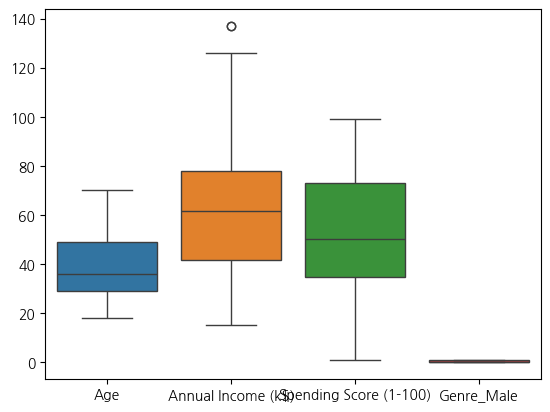

In [13]:
sns.boxplot(data) #대부분 정상범위에 있음을 알 수 있다
# -> standard로 스케일링

In [14]:
from sklearn.preprocessing import StandardScaler

In [15]:
#StandardScaler 객체 생성
scaler = StandardScaler()

In [16]:
data.columns

Index(['Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Genre_Male'], dtype='object')

In [17]:
#스케일링 대상에서 Genre_Male (더미변수) 제외
num_cols = data.drop('Genre_Male', axis=1)
num_cols

,Age,Annual Income (k$),Spending Score (1-100)
0,19,15,39
1,21,15,81
2,20,16,6
3,23,16,77
4,31,17,40
...,...,...,...
195,35,120,79
196,45,126,28
197,32,126,74
198,32,137,18


In [19]:
num_cols.columns #숫자형 컬럼 이름 확인

Index(['Age', 'Annual Income (k$)', 'Spending Score (1-100)'], dtype='object')

In [23]:
#스케일링
scaled = scaler.fit_transform(num_cols) #숫자형 컬럼에 대해 학습(fit) 및 변환 수행
scaled = pd.DataFrame(scaled, columns=num_cols.columns) #변환된 데이터를 다시 데이터프레임으로 변환

#스케일링된 숫자형 데이터와 더미 변수(Genre_Male)를 다시 결합
scaled_df = pd.concat([scaled, data['Genre_Male']], axis=1) 
scaled_df #최종 스케일링된 데이터프레임 확인 

,Age,Annual Income (k$),Spending Score (1-100),Genre_Male
0,-1.424569,-1.738999,-0.434801,True
1,-1.281035,-1.738999,1.195704,True
2,-1.352802,-1.700830,-1.715913,False
3,-1.137502,-1.700830,1.040418,False
4,-0.563369,-1.662660,-0.395980,False
...,...,...,...,...
195,-0.276302,2.268791,1.118061,False
196,0.441365,2.497807,-0.861839,False
197,-0.491602,2.497807,0.923953,True
198,-0.491602,2.917671,-1.250054,True


# 단일연결법/single linkage/최단연결법

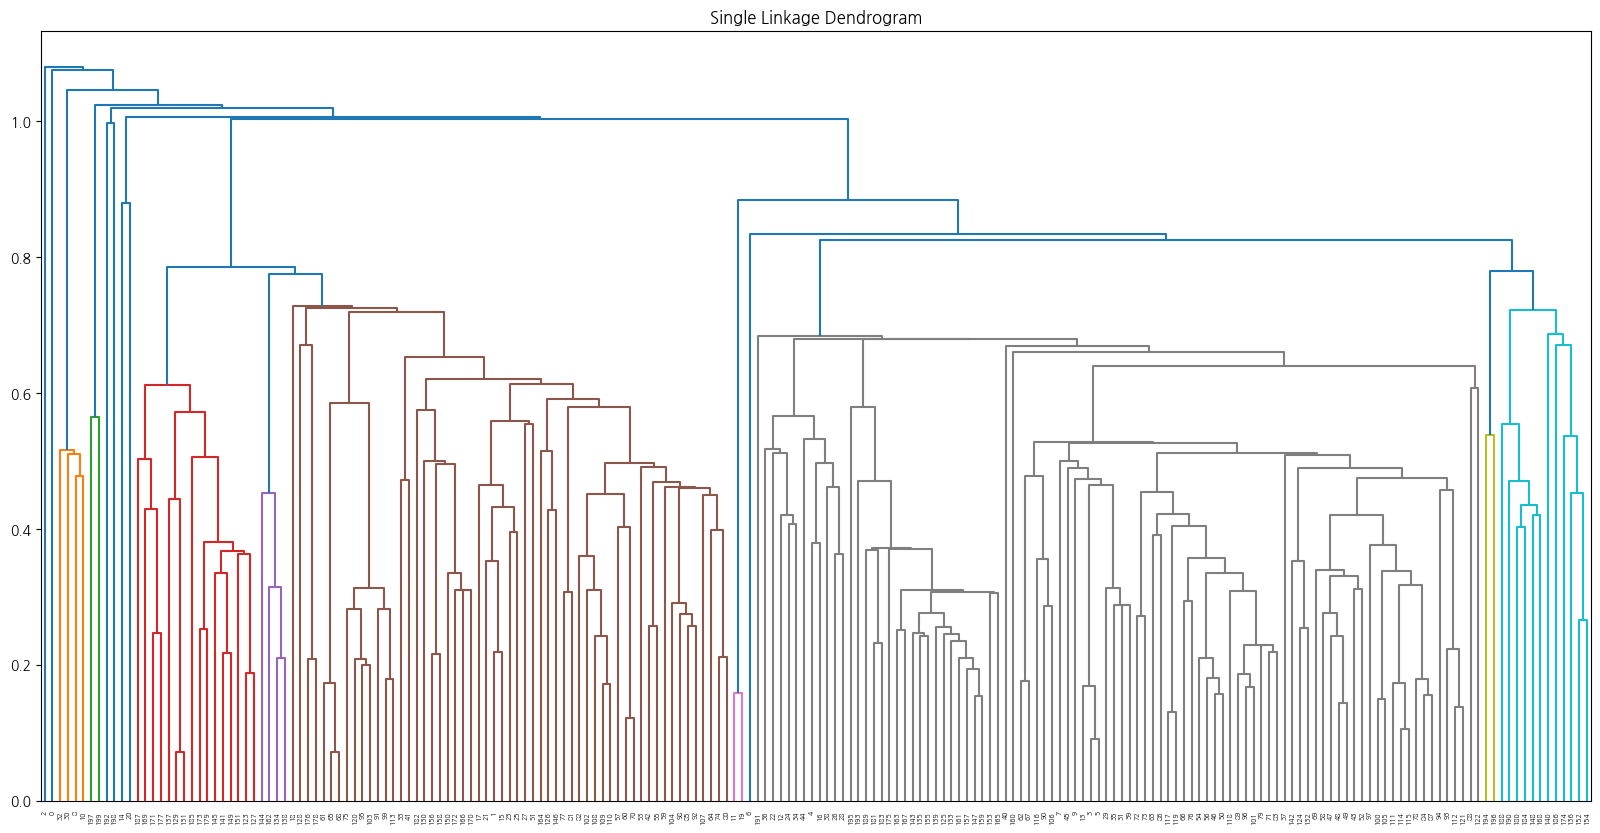

In [33]:
plt.figure(figsize=(20,10))
plt.title('Single Linkage Dendrogram')
dend = shc.dendrogram(shc.linkage(scaled_df, method='single')) 
plt.show()

# 완전연결법/최장연결법/complete linkage

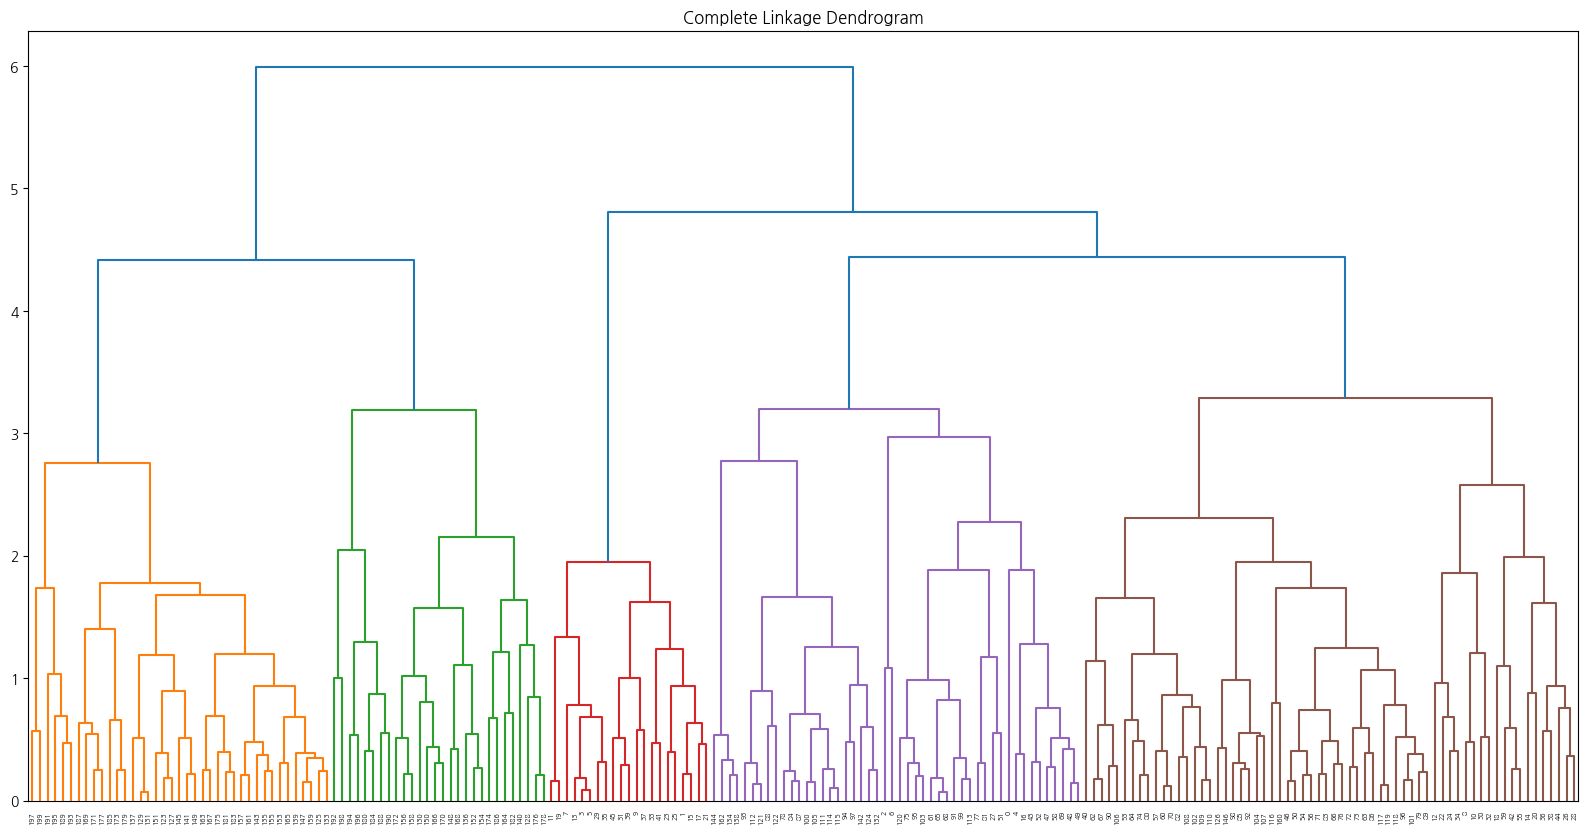

In [34]:
plt.figure(figsize=(20,10))
plt.title('Complete Linkage Dendrogram')
dend = shc.dendrogram(shc.linkage(scaled_df, method='complete'))
plt.show()

# 평균연결법/average linkage

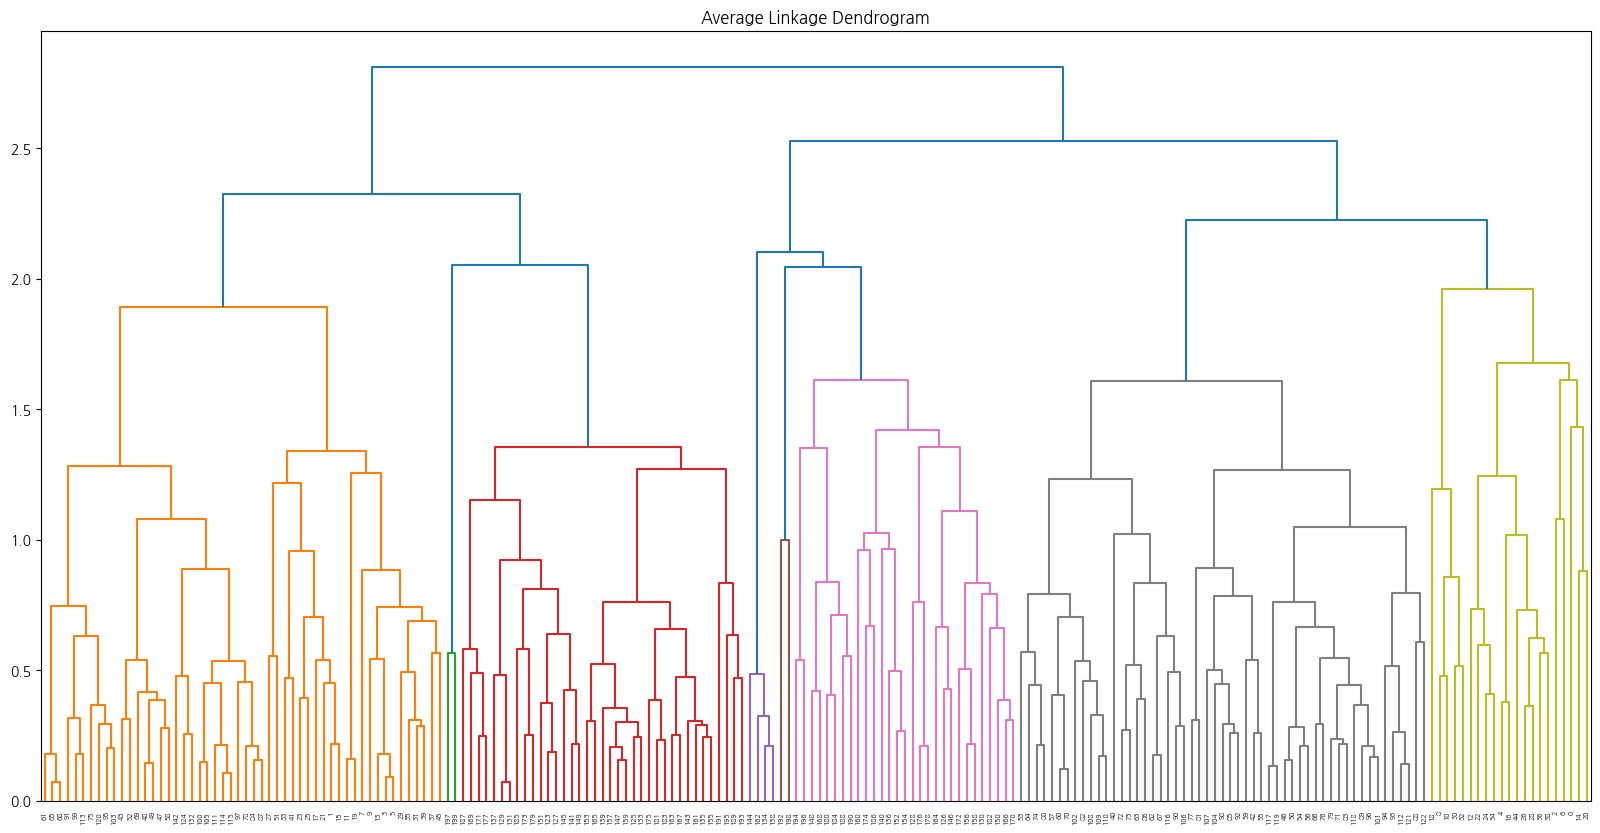

In [35]:
plt.figure(figsize=(20,10))
plt.title('Average Linkage Dendrogram')
dend = shc.dendrogram(shc.linkage(scaled_df, method='average'))
plt.show()

# 중심연결법/centroid linkage

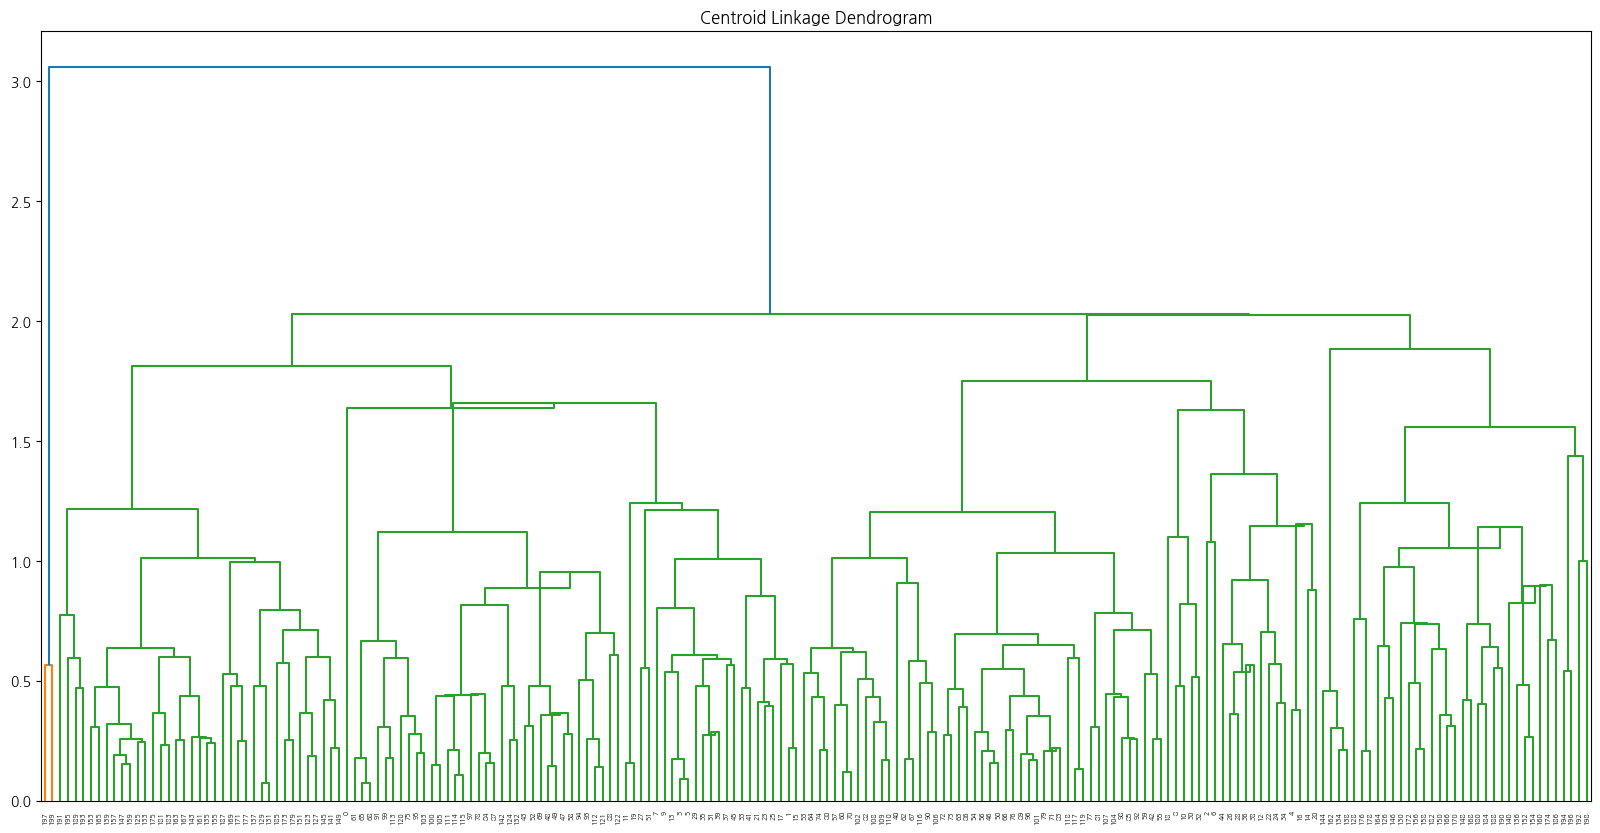

In [36]:
plt.figure(figsize=(20,10))
plt.title('Centroid Linkage Dendrogram')
dend = shc.dendrogram(shc.linkage(scaled_df, method='centroid'))
plt.show()

# 와드연결법/ward linkage

* 군집 내 오차 제곱합(분산)이 최소가 되도록 데이터를 계산(조밀한 군집 형성)

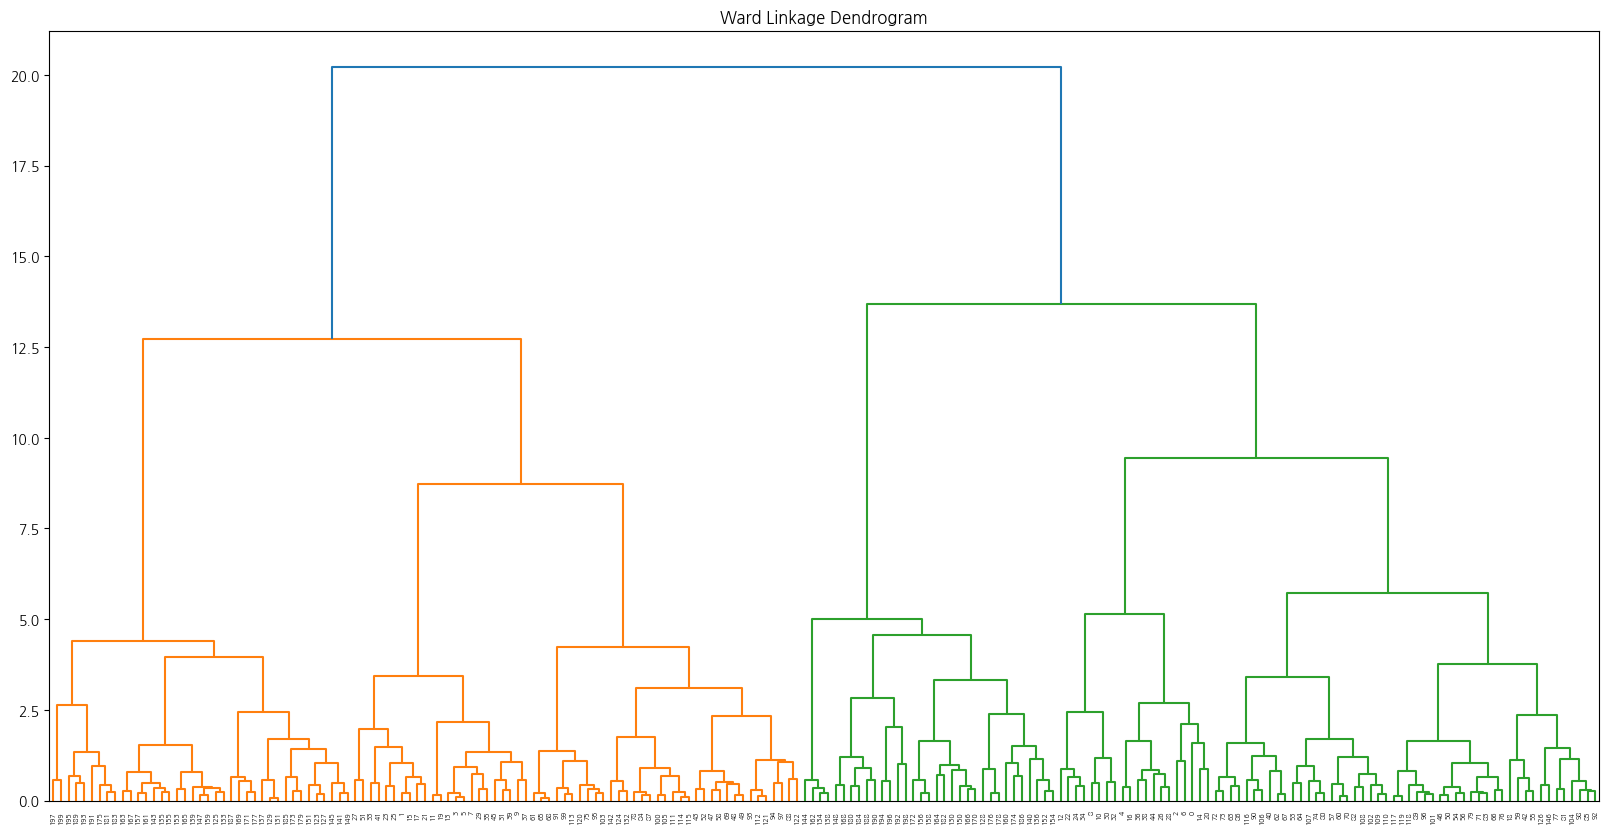

In [37]:
plt.figure(figsize=(20,10))
plt.title('Ward Linkage Dendrogram')
dend = shc.dendrogram(shc.linkage(scaled_df, method='ward'))
plt.show()

# scikit-learn 계층적 군집

In [38]:
from sklearn.cluster import AgglomerativeClustering

In [39]:
#단일 연결법으로 3개의 군집 생성
single = AgglomerativeClustering(n_clusters=3, linkage='single')#몇개만들건지직접지정해야함
result = single.fit_predict(scaled_df) #모델 학습 및 군집 레이블 예측 
result #각 번호 대로 인덱스 쭉 나오게됨 
#각 데이터 포인트의 군집 번호(0,1,2)배열 확인

array([2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

In [40]:
#원본 데이터프레임에 군집 결과 추가
data['single'] = result
data

,Age,Annual Income (k$),Spending Score (1-100),Genre_Male,single
0,19,15,39,True,2
1,21,15,81,True,0
2,20,16,6,False,1
3,23,16,77,False,0
4,31,17,40,False,0
...,...,...,...,...,...
195,35,120,79,False,0
196,45,126,28,False,0
197,32,126,74,True,0
198,32,137,18,True,0


In [44]:
#linkage : {'ward', 'complete', 'average', 'single'}

In [41]:
#평균 연결법으로 3개의 군집 생성
average = AgglomerativeClustering(n_clusters=3, linkage='average')
result = average.fit_predict(scaled_df)
data['average'] = result
data

,Age,Annual Income (k$),Spending Score (1-100),Genre_Male,single,average
0,19,15,39,True,2,1
1,21,15,81,True,0,0
2,20,16,6,False,1,1
3,23,16,77,False,0,0
4,31,17,40,False,0,1
...,...,...,...,...,...,...
195,35,120,79,False,0,0
196,45,126,28,False,0,2
197,32,126,74,True,0,0
198,32,137,18,True,0,2


In [42]:
#완전 연결법으로 3개의 군집 생성
complete = AgglomerativeClustering(n_clusters=3, linkage='complete')
result = complete.fit_predict(scaled_df)
data['complete'] = result
data

,Age,Annual Income (k$),Spending Score (1-100),Genre_Male,single,average,complete
0,19,15,39,True,2,1,0
1,21,15,81,True,0,0,2
2,20,16,6,False,1,1,0
3,23,16,77,False,0,0,2
4,31,17,40,False,0,1,0
...,...,...,...,...,...,...,...
195,35,120,79,False,0,0,1
196,45,126,28,False,0,2,1
197,32,126,74,True,0,0,1
198,32,137,18,True,0,2,1


In [43]:
#와드 연결법으로 3개의 군집 생성(가장 일반적인 선택)
ward = AgglomerativeClustering(n_clusters=3, linkage='ward')
result = ward.fit_predict(scaled_df)
data['ward'] = result
data

,Age,Annual Income (k$),Spending Score (1-100),Genre_Male,single,average,complete,ward
0,19,15,39,True,2,1,0,1
1,21,15,81,True,0,0,2,0
2,20,16,6,False,1,1,0,1
3,23,16,77,False,0,0,2,0
4,31,17,40,False,0,1,0,1
...,...,...,...,...,...,...,...,...
195,35,120,79,False,0,0,1,0
196,45,126,28,False,0,2,1,2
197,32,126,74,True,0,0,1,0
198,32,137,18,True,0,2,1,2


In [47]:
# 'ward' 군집이 1인 데이터의 통계량 확인
# (Age가 많고, Annual Income과 Spending Score가 중간 정도인 그룹)
data[data['ward'] == 1].describe()

,Age,Annual Income (k$),Spending Score (1-100),single,average,complete,ward
count,70.000000,70.000000,70.000000,70.000000,70.000000,70.0,70.0
mean,51.757143,45.514286,39.900000,0.042857,1.028571,0.0,1.0
std,11.512357,15.906195,16.076042,0.265707,0.167802,0.0,0.0
min,19.000000,15.000000,3.000000,0.000000,1.000000,0.0,1.0
25%,46.250000,33.250000,35.000000,0.000000,1.000000,0.0,1.0
50%,50.000000,48.000000,45.500000,0.000000,1.000000,0.0,1.0
75%,60.000000,58.750000,51.000000,0.000000,1.000000,0.0,1.0
max,70.000000,77.000000,60.000000,2.000000,2.000000,0.0,1.0


In [48]:
# 'ward' 군집이 0인 데이터의 통계량 확인
# (Age가 적고, Annual Income과 Spending Score가 중간 또는 높은 그룹)
data[data['ward'] == 0].describe()

,Age,Annual Income (k$),Spending Score (1-100),single,average,complete,ward
count,97.000000,97.000000,97.000000,97.0,97.000000,97.000000,97.0
mean,28.649485,61.711340,69.206186,0.0,0.061856,0.835052,0.0
std,6.219997,26.677456,18.078497,0.0,0.242145,0.759391,0.0
min,18.000000,15.000000,29.000000,0.0,0.000000,0.000000,0.0
25%,23.000000,40.000000,54.000000,0.0,0.000000,0.000000,0.0
50%,29.000000,64.000000,73.000000,0.0,0.000000,1.000000,0.0
75%,32.000000,78.000000,85.000000,0.0,0.000000,1.000000,0.0
max,40.000000,137.000000,99.000000,0.0,1.000000,2.000000,0.0


In [49]:
# 'ward' 군집이 2인 데이터의 통계량 확인
# (Annual Income이 높고, Spending Score가 낮은 그룹)
data[data['ward'] == 2].describe()

,Age,Annual Income (k$),Spending Score (1-100),single,average,complete,ward
count,33.000000,33.000000,33.000000,33.0,33.0,33.000000,33.0
mean,41.454545,89.090909,16.181818,0.0,2.0,0.848485,2.0
std,11.172206,16.451375,9.422230,0.0,0.0,0.364110,0.0
min,19.000000,71.000000,1.000000,0.0,2.0,0.000000,2.0
25%,34.000000,78.000000,10.000000,0.0,2.0,1.000000,2.0
50%,42.000000,86.000000,15.000000,0.0,2.0,1.000000,2.0
75%,47.000000,98.000000,22.000000,0.0,2.0,1.000000,2.0
max,59.000000,137.000000,39.000000,0.0,2.0,1.000000,2.0


# 비계층적 군집 - 데이터 수가 많을 때 사용 >5000
* k-means(k 평균 군집): 거리를 기반으로 군집 형성, 이상치에 민감함
* StandardScaler를 사용, 데이터에 이상치가 있으면 RobustScaler 사용
* 이상치가 많은 데이터를 분석시 평균이 아닌 **중앙값**을 이용해서 군집 형성

In [50]:
df = pd.read_csv("./data/고객이탈예측.csv", encoding='cp949')
df

,회원ID,성별,고연령,배우자,피부양자,가입기간,전화서비스,2회선이상,인터넷서비스,온라인보안,...,기기보호서비스,기술지원,스트리밍TV,스트리밍Movies,약정옵션,온라인고지서,지불수단,월요금,합산요금,이탈여부
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   회원ID        7043 non-null   object 
 1   성별          7043 non-null   object 
 2   고연령         7043 non-null   int64  
 3   배우자         7043 non-null   object 
 4   피부양자        7043 non-null   object 
 5   가입기간        7043 non-null   int64  
 6   전화서비스       7043 non-null   object 
 7   2회선이상       7043 non-null   object 
 8   인터넷서비스      7043 non-null   object 
 9   온라인보안       7043 non-null   object 
 10  온라인백업       7043 non-null   object 
 11  기기보호서비스     7043 non-null   object 
 12  기술지원        7043 non-null   object 
 13  스트리밍TV      7043 non-null   object 
 14  스트리밍Movies  7043 non-null   object 
 15  약정옵션        7043 non-null   object 
 16  온라인고지서      7043 non-null   object 
 17  지불수단        7043 non-null   object 
 18  월요금         7043 non-null   float64
 19  합산요금        7043 non-null  

In [53]:
# 숫자형 컬럼 기술 통계량 확인 (이상치 확인 목적)
df.describe()

,고연령,가입기간,월요금
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


<Axes: >

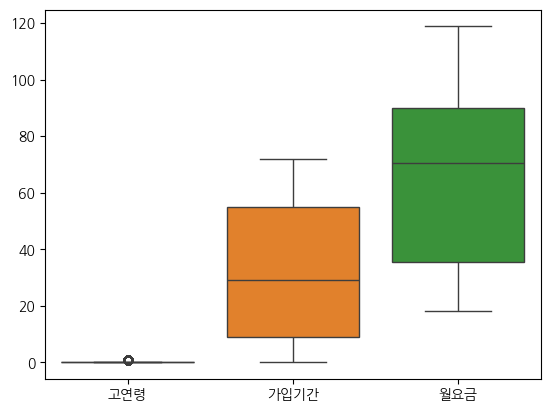

In [54]:
sns.boxplot(df)

In [55]:
df2 = df.copy()

In [56]:
df.columns

Index(['회원ID', '성별', '고연령', '배우자', '피부양자', '가입기간', '전화서비스', '2회선이상', '인터넷서비스',
       '온라인보안', '온라인백업', '기기보호서비스', '기술지원', '스트리밍TV', '스트리밍Movies', '약정옵션',
       '온라인고지서', '지불수단', '월요금', '합산요금', '이탈여부'],
      dtype='object')

In [57]:
df = df.drop('회원ID', axis=1)
df

,성별,고연령,배우자,피부양자,가입기간,전화서비스,2회선이상,인터넷서비스,온라인보안,온라인백업,기기보호서비스,기술지원,스트리밍TV,스트리밍Movies,약정옵션,온라인고지서,지불수단,월요금,합산요금,이탈여부
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [59]:
df[df['합산요금'] == " "] #'합산요금' 컬럼에 공백 문자열(" ")이 있는 행 확인

# 이 행들은 가입기간이 0개월인 고객이므로, 합산요금을 0.0으로 대체하는 것이 합리적임.
# (월요금은 부과되었으나 아직 합산되지 않았거나, 기타 이유로 데이터가 누락된 경우)

,성별,고연령,배우자,피부양자,가입기간,전화서비스,2회선이상,인터넷서비스,온라인보안,온라인백업,기기보호서비스,기술지원,스트리밍TV,스트리밍Movies,약정옵션,온라인고지서,지불수단,월요금,합산요금,이탈여부
488,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1340,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3331,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
3826,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5218,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
6670,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


In [62]:
df['합산요금'] = df['합산요금'].str.replace(" ", "0.0")

In [63]:
# '합산요금' 컬럼의 데이터 타입을 float (실수형)으로 변환
df['합산요금'] = df['합산요금'].astype(float)

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   성별          7043 non-null   object 
 1   고연령         7043 non-null   int64  
 2   배우자         7043 non-null   object 
 3   피부양자        7043 non-null   object 
 4   가입기간        7043 non-null   int64  
 5   전화서비스       7043 non-null   object 
 6   2회선이상       7043 non-null   object 
 7   인터넷서비스      7043 non-null   object 
 8   온라인보안       7043 non-null   object 
 9   온라인백업       7043 non-null   object 
 10  기기보호서비스     7043 non-null   object 
 11  기술지원        7043 non-null   object 
 12  스트리밍TV      7043 non-null   object 
 13  스트리밍Movies  7043 non-null   object 
 14  약정옵션        7043 non-null   object 
 15  온라인고지서      7043 non-null   object 
 16  지불수단        7043 non-null   object 
 17  월요금         7043 non-null   float64
 18  합산요금        7043 non-null   float64
 19  이탈여부        7043 non-null  

### 범주형 데이터 인코딩 및 스케일링

In [71]:
#범주형(object) 컬럼 선택
cat_cols = df.select_dtypes(include='object')
cat_cols['고연령'] = df['고연령']
cat_cols = pd.get_dummies(cat_cols, drop_first=True) # K-Means는 숫자형 데이터만 처리 가능하므로, 범주형 데이터를 One-Hot Encoding으로 변환
cat_cols

,고연령,성별_Male,배우자_Yes,피부양자_Yes,전화서비스_Yes,2회선이상_No phone service,2회선이상_Yes,인터넷서비스_Fiber optic,인터넷서비스_No,온라인보안_No internet service,...,스트리밍TV_Yes,스트리밍Movies_No internet service,스트리밍Movies_Yes,약정옵션_One year,약정옵션_Two year,온라인고지서_Yes,지불수단_Credit card (automatic),지불수단_Electronic check,지불수단_Mailed check,이탈여부_Yes
0,0,False,True,False,False,True,False,False,False,False,...,False,False,False,False,False,True,False,True,False,False
1,0,True,False,False,True,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False
2,0,True,False,False,True,False,False,False,False,False,...,False,False,False,False,False,True,False,False,True,True
3,0,True,False,False,False,True,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
4,0,False,False,False,True,False,False,True,False,False,...,False,False,False,False,False,True,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,True,True,True,True,False,True,False,False,False,...,True,False,True,True,False,True,False,False,True,False
7039,0,False,True,True,True,False,True,True,False,False,...,True,False,True,True,False,True,True,False,False,False
7040,0,False,True,True,False,True,False,False,False,False,...,False,False,False,False,False,True,False,True,False,False
7041,1,True,True,False,True,False,True,True,False,False,...,False,False,False,False,False,True,False,False,True,True


In [68]:
# 숫자형(int64, float64) 컬럼 선택 ('고연령'은 0/1 값이므로 제외)num_cols = df.select_dtypes(exclude='object')
num_cols = num_cols.drop('고연령', axis=1)
num_cols

,가입기간,월요금,합산요금
0,1,29.85,29.85
1,34,56.95,1889.50
2,2,53.85,108.15
3,45,42.30,1840.75
4,2,70.70,151.65
...,...,...,...
7038,24,84.80,1990.50
7039,72,103.20,7362.90
7040,11,29.60,346.45
7041,4,74.40,306.60


In [69]:
#단위차이가 크기 때문에 스케일링 해줘야함

# 숫자컬럼 스케일링

In [70]:
#이상값 없기 때문에 standerd scaler
ss = StandardScaler()
ss_scaled = ss.fit_transform(num_cols)
ss_scaled = pd.DataFrame(ss_scaled, columns=num_cols.columns)
ss_scaled

,가입기간,월요금,합산요금
0,-1.277445,-1.160323,-0.992611
1,0.066327,-0.259629,-0.172165
2,-1.236724,-0.362660,-0.958066
3,0.514251,-0.746535,-0.193672
4,-1.236724,0.197365,-0.938874
...,...,...,...
7038,-0.340876,0.665992,-0.127605
7039,1.613701,1.277533,2.242606
7040,-0.870241,-1.168632,-0.852932
7041,-1.155283,0.320338,-0.870513


In [72]:
#범주형 데이터와 스케일링된 숫자형 데이터를 다시 결합 
#'고연령'컬럼이 cat_cols에 포함되어 있으므로, num_cols에서 제거하고 cat_cols와 결합
scaled_df2 = pd.concat([cat_cols, ss_scaled], axis=1)
scaled_df2 #최종 K-Means 분석용 데이터프레임 확인

,고연령,성별_Male,배우자_Yes,피부양자_Yes,전화서비스_Yes,2회선이상_No phone service,2회선이상_Yes,인터넷서비스_Fiber optic,인터넷서비스_No,온라인보안_No internet service,...,약정옵션_One year,약정옵션_Two year,온라인고지서_Yes,지불수단_Credit card (automatic),지불수단_Electronic check,지불수단_Mailed check,이탈여부_Yes,가입기간,월요금,합산요금
0,0,False,True,False,False,True,False,False,False,False,...,False,False,True,False,True,False,False,-1.277445,-1.160323,-0.992611
1,0,True,False,False,True,False,False,False,False,False,...,True,False,False,False,False,True,False,0.066327,-0.259629,-0.172165
2,0,True,False,False,True,False,False,False,False,False,...,False,False,True,False,False,True,True,-1.236724,-0.362660,-0.958066
3,0,True,False,False,False,True,False,False,False,False,...,True,False,False,False,False,False,False,0.514251,-0.746535,-0.193672
4,0,False,False,False,True,False,False,True,False,False,...,False,False,True,False,True,False,True,-1.236724,0.197365,-0.938874
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,True,True,True,True,False,True,False,False,False,...,True,False,True,False,False,True,False,-0.340876,0.665992,-0.127605
7039,0,False,True,True,True,False,True,True,False,False,...,True,False,True,True,False,False,False,1.613701,1.277533,2.242606
7040,0,False,True,True,False,True,False,False,False,False,...,False,False,True,False,True,False,False,-0.870241,-1.168632,-0.852932
7041,1,True,True,False,True,False,True,True,False,False,...,False,False,True,False,False,True,True,-1.155283,0.320338,-0.870513


# k-means로 군집 분석하기

In [73]:
from sklearn.cluster import KMeans

In [74]:
# n_clusters=8로 K-Means 모델 생성 및 학습
# (이전에 엘보우/실루엣 지수 계산 없이 임의로 8을 지정한 상태)
km = KMeans(random_state=42)
km.fit(scaled_df2)

# 각 데이터 포인트의 군집 레이블 예측
result = km.labels_
result

array([7, 5, 7, ..., 7, 2, 1], dtype=int32)

In [75]:
df['kmeans8'] = result
df

,성별,고연령,배우자,피부양자,가입기간,전화서비스,2회선이상,인터넷서비스,온라인보안,온라인백업,...,기술지원,스트리밍TV,스트리밍Movies,약정옵션,온라인고지서,지불수단,월요금,합산요금,이탈여부,kmeans8
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,7
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,...,No,No,No,One year,No,Mailed check,56.95,1889.50,No,5
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,7
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,...,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,5
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,...,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No,5
7039,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,...,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No,1
7040,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,...,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No,7
7041,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,...,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,Yes,2


In [77]:
df[df['kmeans8'] == 0].describe(include='all')

,성별,고연령,배우자,피부양자,가입기간,전화서비스,2회선이상,인터넷서비스,온라인보안,온라인백업,...,기술지원,스트리밍TV,스트리밍Movies,약정옵션,온라인고지서,지불수단,월요금,합산요금,이탈여부,kmeans8
count,614,614.000000,614,614,614.000000,614,614,614,614,614,...,614,614,614,614,614,614,614.000000,614.000000,614,614.0
unique,2,NaN,2,2,NaN,2,3,2,2,2,...,2,2,2,3,2,4,NaN,NaN,2,NaN
top,Male,NaN,Yes,No,NaN,Yes,Yes,DSL,Yes,Yes,...,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),NaN,NaN,No,NaN
freq,314,NaN,482,314,NaN,526,348,588,472,448,...,497,419,434,504,329,253,NaN,NaN,600,NaN
mean,NaN,0.097720,NaN,NaN,64.369707,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,75.510098,4853.148941,NaN,0.0
std,NaN,0.297178,NaN,NaN,8.305257,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,11.117974,955.320256,NaN,0.0
min,NaN,0.000000,NaN,NaN,23.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,43.950000,2198.300000,NaN,0.0
25%,NaN,0.000000,NaN,NaN,60.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,66.900000,4123.150000,NaN,0.0
50%,NaN,0.000000,NaN,NaN,67.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,77.675000,4772.375000,NaN,0.0
75%,NaN,0.000000,NaN,NaN,71.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,84.487500,5606.375000,NaN,0.0


In [78]:
df[df['kmeans8'] == 1].describe(include='all')

,성별,고연령,배우자,피부양자,가입기간,전화서비스,2회선이상,인터넷서비스,온라인보안,온라인백업,...,기술지원,스트리밍TV,스트리밍Movies,약정옵션,온라인고지서,지불수단,월요금,합산요금,이탈여부,kmeans8
count,863,863.000000,863,863,863.000000,863,863,863,863,863,...,863,863,863,863,863,863,863.000000,863.000000,863,863.0
unique,2,NaN,2,2,NaN,1,2,2,2,2,...,2,2,2,3,2,4,NaN,NaN,2,NaN
top,Female,NaN,Yes,No,NaN,Yes,Yes,Fiber optic,Yes,Yes,...,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),NaN,NaN,No,NaN
freq,440,NaN,638,597,NaN,863,741,860,456,660,...,473,713,723,380,662,279,NaN,NaN,729,NaN
mean,NaN,0.238702,NaN,NaN,64.066049,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,103.659849,6650.404171,NaN,1.0
std,NaN,0.426538,NaN,NaN,7.190419,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,8.112960,957.058563,NaN,0.0
min,NaN,0.000000,NaN,NaN,41.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,75.650000,4473.450000,NaN,1.0
25%,NaN,0.000000,NaN,NaN,59.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,98.800000,5826.075000,NaN,1.0
50%,NaN,0.000000,NaN,NaN,66.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,104.850000,6671.700000,NaN,1.0
75%,NaN,0.000000,NaN,NaN,71.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,109.625000,7392.300000,NaN,1.0


In [79]:
df[df['kmeans8'] == 2].describe(include='all')

,성별,고연령,배우자,피부양자,가입기간,전화서비스,2회선이상,인터넷서비스,온라인보안,온라인백업,...,기술지원,스트리밍TV,스트리밍Movies,약정옵션,온라인고지서,지불수단,월요금,합산요금,이탈여부,kmeans8
count,1356,1356.000000,1356,1356,1356.000000,1356,1356,1356,1356,1356,...,1356,1356,1356,1356,1356,1356,1356.000000,1356.000000,1356,1356.0
unique,2,NaN,2,2,NaN,1,2,2,2,2,...,2,2,2,2,2,4,NaN,NaN,2,NaN
top,Female,NaN,No,No,NaN,Yes,No,Fiber optic,No,No,...,No,No,No,Month-to-month,Yes,Electronic check,NaN,NaN,Yes,NaN
freq,727,NaN,980,1181,NaN,1356,754,1308,1194,1075,...,1205,835,836,1337,1079,923,NaN,NaN,889,NaN
mean,NaN,0.258850,NaN,NaN,9.055310,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,82.253761,748.961578,NaN,2.0
std,NaN,0.438164,NaN,NaN,7.555495,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,9.798087,618.679485,NaN,0.0
min,NaN,0.000000,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,59.450000,59.850000,NaN,2.0
25%,NaN,0.000000,NaN,NaN,2.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,74.550000,193.037500,NaN,2.0
50%,NaN,0.000000,NaN,NaN,7.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,80.450000,580.050000,NaN,2.0
75%,NaN,1.000000,NaN,NaN,14.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,89.562500,1184.250000,NaN,2.0


In [80]:
df[df['kmeans8'] == 3].describe(include='all')

,성별,고연령,배우자,피부양자,가입기간,전화서비스,2회선이상,인터넷서비스,온라인보안,온라인백업,...,기술지원,스트리밍TV,스트리밍Movies,약정옵션,온라인고지서,지불수단,월요금,합산요금,이탈여부,kmeans8
count,633,633.000000,633,633,633.000000,633,633,633,633,633,...,633,633,633,633,633,633,633.000000,633.000000,633,633.0
unique,2,NaN,2,2,NaN,1,2,1,1,1,...,1,1,1,3,2,4,NaN,NaN,2,NaN
top,Female,NaN,Yes,Yes,NaN,Yes,No,No,No internet service,No internet service,...,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic),NaN,NaN,No,NaN
freq,320,NaN,441,336,NaN,633,382,633,633,633,...,633,633,633,503,444,204,NaN,NaN,625,NaN
mean,NaN,0.044234,NaN,NaN,56.025276,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,21.931517,1234.711295,NaN,3.0
std,NaN,0.205777,NaN,NaN,12.660213,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.520186,340.208203,NaN,0.0
min,NaN,0.000000,NaN,NaN,22.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,18.400000,487.950000,NaN,3.0
25%,NaN,0.000000,NaN,NaN,46.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,19.800000,967.900000,NaN,3.0
50%,NaN,0.000000,NaN,NaN,57.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,20.500000,1218.450000,NaN,3.0
75%,NaN,0.000000,NaN,NaN,68.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,24.700000,1468.750000,NaN,3.0


# 군집의 최적 개수 정하기
* elbow method
  * 군집 분석의 응집도(inertia_) - 요소들이 얼마나 모여있는지 판단하는 지표
  * inertia_값이 작을 수록 군집이 잘 형성됨
  * elbow method는 inertia_를 출력하고 시각화 한 뒤 응집도의 감소폭이 급격한 변화가 일어나는 지점을 최적 군집 수로 채택
* 실루엣 지수 1에 가까우면 좋은 군집 수 (범위 0-1)

In [81]:
# 현재 k=8 모델의 응집도 출력
print(km.inertia_)

24209.80005060706


In [82]:
# k=2부터 k=20까지 반복하며 응집도(inertia) 계산
inertia = []
for i in range(2,21):
    km = KMeans(n_clusters=i, random_state=42)
    km.fit(scaled_df2)
    inertia.append(km.inertia_)
inertia

[43374.18243887566,
 31994.01479862794,
 29339.87563933933,
 27584.629093848493,
 26444.329679554132,
 25749.759028719083,
 24209.80005060706,
 23690.381065814323,
 23081.54710855729,
 22527.917241701063,
 22138.29380245032,
 21836.915733081376,
 21580.902381005533,
 21422.29489137893,
 21162.378510349798,
 20835.701505507994,
 20670.210044736676,
 20445.13804824325,
 20299.489532932737]

* elbow method로 계산한 최적 군집 수는 3

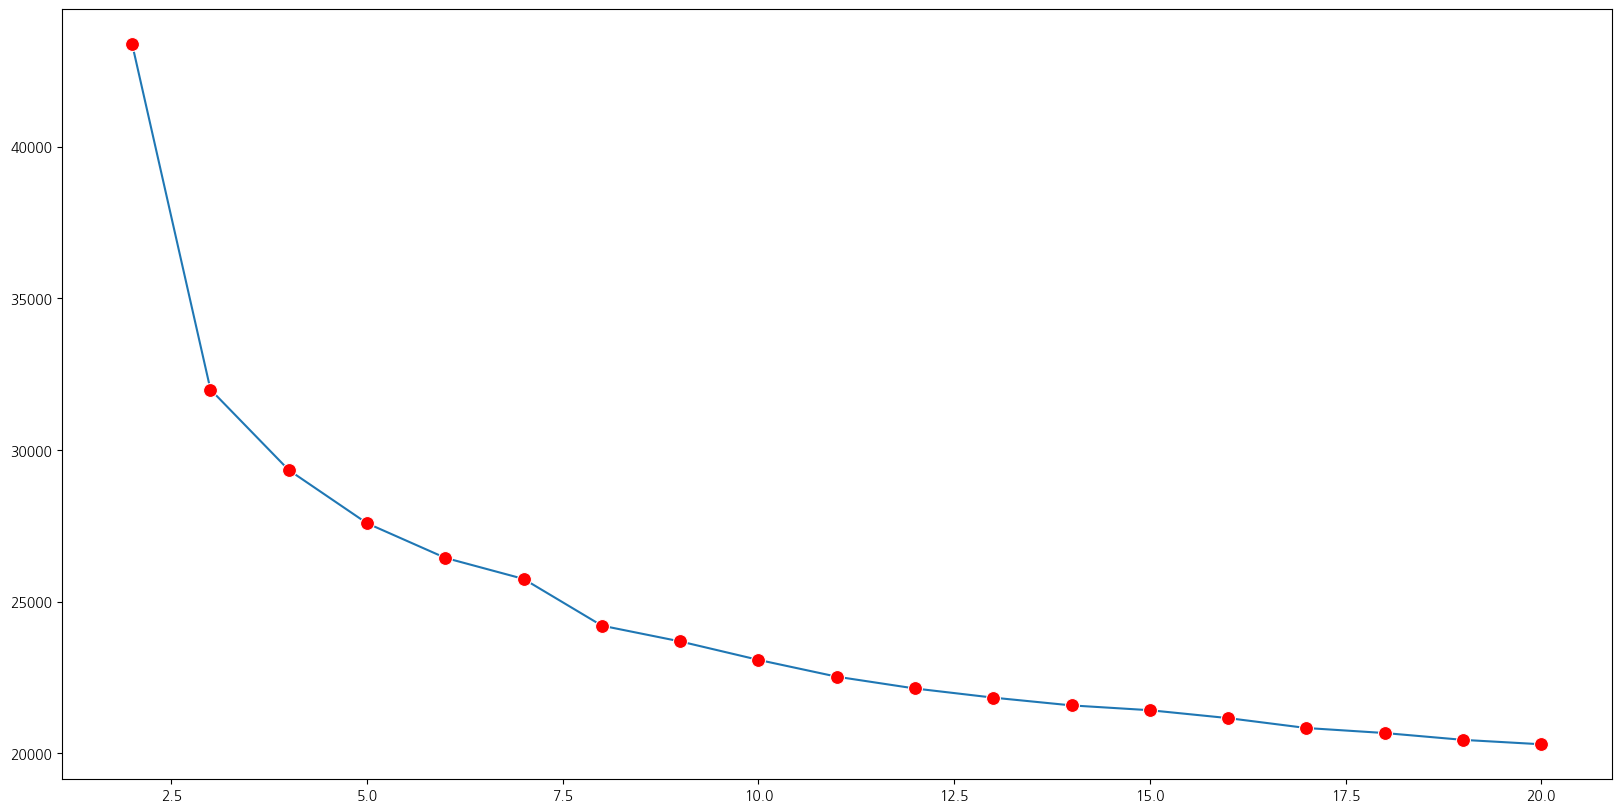

In [84]:
# 엘보우 차트 시각화
plt.figure(figsize=(20,10)) # x축: 군집 개수 (2~20), y축: 응집도 (inertia)
sns.lineplot(x=range(2, 21), y=inertia, marker='o', markersize=10, markerfacecolor='red')
plt.show()

# 시각화 결과, k=3 지점에서 기울기가 완만해지는 "팔꿈치(Elbow)"가 관찰되므로, 
# 최적 군집 수는 3으로 판단.

# 실루엣 지수를 출력해서 최적군집 개수 구하기
* 실루엣 지수를 구하기 위해서는 최소 2개 이상의 군집이 필요
* 실루엣 지수가 가장 높은 클러스터 개수가 최적 군집 개수(1에 가까울 수록 좋음)

In [85]:
from sklearn.metrics import silhouette_score

In [87]:
sil_score = []
for i in range(2,21):
    km2 = KMeans(n_clusters=i, random_state=42)
    km2.fit(scaled_df2)
    labels = km2.labels_
    sil_score.append(silhouette_score(scaled_df2, labels)) # silhouette_score(데이터, 레이블) 계산
sil_score

[np.float64(0.23114136530579366),
 np.float64(0.2795402575361415),
 np.float64(0.22605560326074667),
 np.float64(0.20214223640397508),
 np.float64(0.18454819485404964),
 np.float64(0.17404251855761274),
 np.float64(0.15134167054930217),
 np.float64(0.14304983730701767),
 np.float64(0.13725380808787532),
 np.float64(0.1361302462592312),
 np.float64(0.13410651910318905),
 np.float64(0.12859599044872816),
 np.float64(0.12894604831287165),
 np.float64(0.12553613112548542),
 np.float64(0.12554660635355555),
 np.float64(0.1071042692740527),
 np.float64(0.10674088444429225),
 np.float64(0.10699167305891794),
 np.float64(0.10612507294731718)]

## 실루엣지수 계산 결과 최적 군집의 개수는 3개

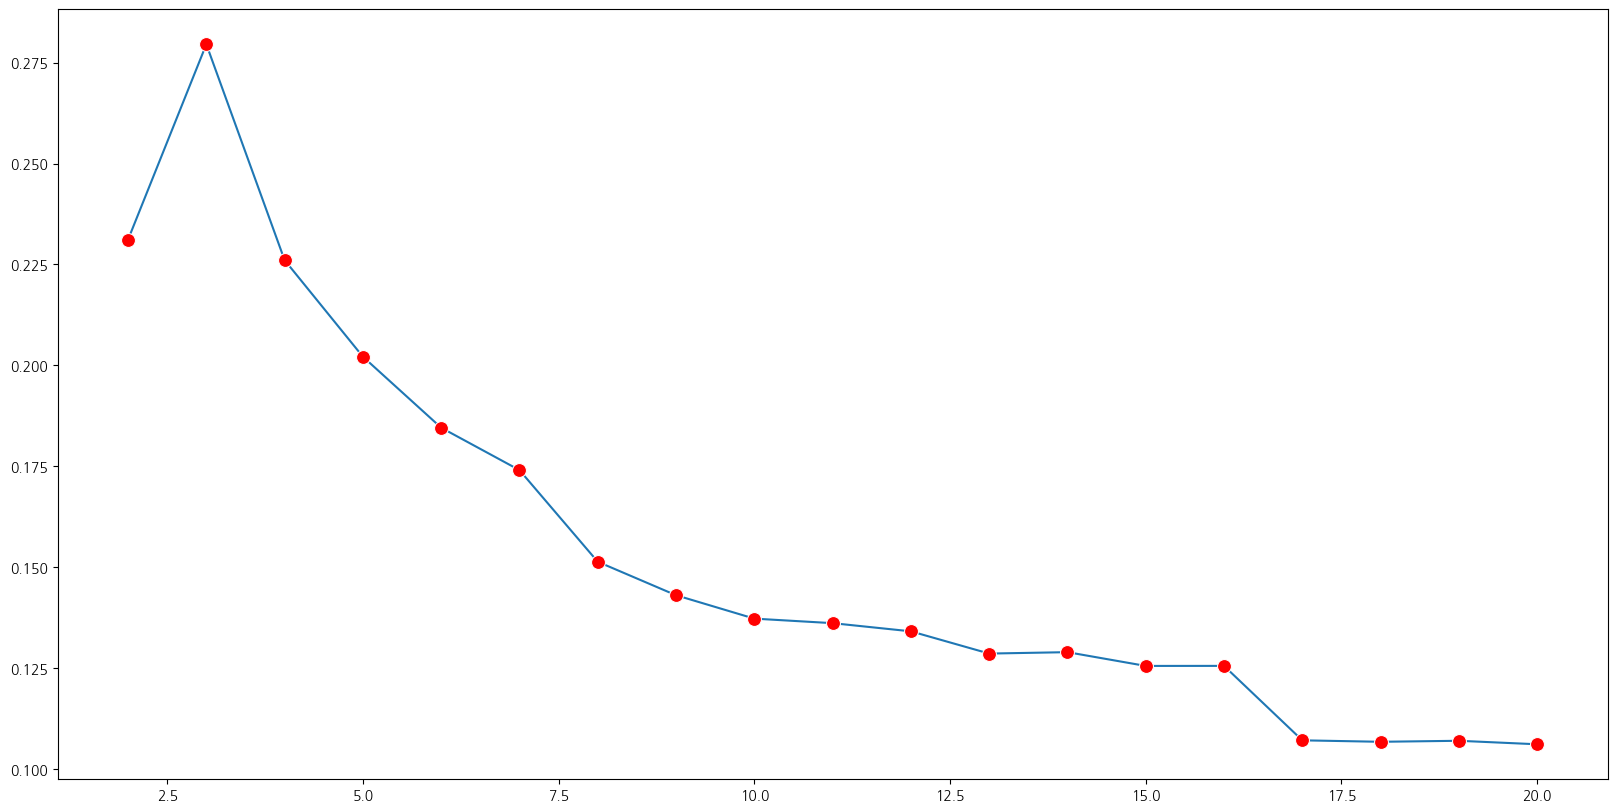

In [88]:
plt.figure(figsize=(20,10)) # x축: 군집 개수 (2~20), y축: 실루엣 지수
sns.lineplot(x=range(2, 21), y=sil_score, marker='o', markersize=10, markerfacecolor='red')
plt.show()

# 실루엣 지수 계산 결과, k=3에서 가장 높은 값 (약 0.279)을 보이므로, 
# 최적 군집 수는 3으로 판단.

In [89]:
km3 = KMeans(n_clusters=3, random_state=42) # n_clusters=3으로 K-Means 모델 생성 및 학습
km3.fit(scaled_df2)
labels = km3.labels_ # 각 데이터 포인트의 군집 레이블 예측

In [90]:
# 원본 데이터프레임에 k=3 군집 결과 추가
df ['kmeans3'] = labels
df

,성별,고연령,배우자,피부양자,가입기간,전화서비스,2회선이상,인터넷서비스,온라인보안,온라인백업,...,스트리밍TV,스트리밍Movies,약정옵션,온라인고지서,지불수단,월요금,합산요금,이탈여부,kmeans8,kmeans3
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,...,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,7,2
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,...,No,No,One year,No,Mailed check,56.95,1889.50,No,5,2
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,...,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,7,2
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,...,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,5,2
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,...,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,...,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No,5,2
7039,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,...,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No,1,1
7040,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,...,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No,7,2
7041,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,...,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,Yes,2,2


In [92]:
# 군집 0의 특성 확인 (통계 분석을 통해 군집 특성 파악)
# No internet service 고객들이 주로 묶인 것을 확인
df[df ['kmeans3'] == 0].describe(include='all')

,성별,고연령,배우자,피부양자,가입기간,전화서비스,2회선이상,인터넷서비스,온라인보안,온라인백업,...,스트리밍TV,스트리밍Movies,약정옵션,온라인고지서,지불수단,월요금,합산요금,이탈여부,kmeans8,kmeans3
count,1526,1526.000000,1526,1526,1526.000000,1526,1526,1526,1526,1526,...,1526,1526,1526,1526,1526,1526.000000,1526.000000,1526,1526.000000,1526.0
unique,2,NaN,2,2,NaN,1,2,1,1,1,...,1,1,3,2,4,NaN,NaN,2,NaN,NaN
top,Male,NaN,No,No,NaN,Yes,No,No,No internet service,No internet service,...,No internet service,No internet service,Two year,No,Mailed check,NaN,NaN,No,NaN,NaN
freq,779,NaN,788,883,NaN,1526,1184,1526,1526,1526,...,1526,1526,638,1080,741,NaN,NaN,1413,NaN,NaN
mean,NaN,0.034076,NaN,NaN,30.547182,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,21.079194,662.604784,NaN,4.755570,0.0
std,NaN,0.181484,NaN,NaN,24.356507,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2.164221,555.627705,NaN,1.478552,0.0
min,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,18.250000,0.000000,NaN,3.000000,0.0
25%,NaN,0.000000,NaN,NaN,8.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,19.700000,157.825000,NaN,3.000000,0.0
50%,NaN,0.000000,NaN,NaN,25.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,20.150000,519.200000,NaN,6.000000,0.0
75%,NaN,0.000000,NaN,NaN,52.750000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,20.900000,1108.650000,NaN,6.000000,0.0


In [93]:
# 군집 1의 특성 확인
# 가입기간, 월요금, 합산요금이 모두 높고, Fiber optic 인터넷 사용자가 많은 그룹 (장기/고가치 고객)
df[df ['kmeans3'] == 1].describe(include='all')

,성별,고연령,배우자,피부양자,가입기간,전화서비스,2회선이상,인터넷서비스,온라인보안,온라인백업,...,스트리밍TV,스트리밍Movies,약정옵션,온라인고지서,지불수단,월요금,합산요금,이탈여부,kmeans8,kmeans3
count,2274,2274.000000,2274,2274,2274.000000,2274,2274,2274,2274,2274,...,2274,2274,2274,2274,2274,2274.000000,2274.000000,2274,2274.000000,2274.0
unique,2,NaN,2,2,NaN,2,3,2,2,2,...,2,2,3,2,4,NaN,NaN,2,NaN,NaN
top,Male,NaN,Yes,No,NaN,Yes,Yes,Fiber optic,Yes,Yes,...,Yes,Yes,Two year,Yes,Bank transfer (automatic),NaN,NaN,No,NaN,NaN
freq,1147,NaN,1563,1486,NaN,2107,1572,1430,1228,1531,...,1622,1635,967,1564,724,NaN,NaN,1948,NaN,NaN
mean,NaN,0.205365,NaN,NaN,57.912489,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,89.322933,5158.676759,NaN,1.884785,1.0
std,NaN,0.404057,NaN,NaN,12.110751,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,17.830285,1522.205640,NaN,1.834774,0.0
min,NaN,0.000000,NaN,NaN,23.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,35.700000,2198.300000,NaN,0.000000,1.0
25%,NaN,0.000000,NaN,NaN,49.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,78.750000,3889.887500,NaN,0.000000,1.0
50%,NaN,0.000000,NaN,NaN,60.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,92.775000,4994.375000,NaN,1.000000,1.0
75%,NaN,0.000000,NaN,NaN,69.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,104.100000,6315.737500,NaN,4.000000,1.0


In [94]:
# 군집 2의 특성 확인
# 가입기간, 월요금, 합산요금이 모두 낮고, Month-to-month 약정 고객이 많은 그룹 (단기/저가치 고객, 이탈 가능성 높음)
df[df ['kmeans3'] == 2].describe(include='all')

,성별,고연령,배우자,피부양자,가입기간,전화서비스,2회선이상,인터넷서비스,온라인보안,온라인백업,...,스트리밍TV,스트리밍Movies,약정옵션,온라인고지서,지불수단,월요금,합산요금,이탈여부,kmeans8,kmeans3
count,3243,3243.000000,3243,3243,3243.000000,3243,3243,3243,3243,3243,...,3243,3243,3243,3243,3243,3243.000000,3243.000000,3243,3243.000000,3243.0
unique,2,NaN,2,2,NaN,2,3,2,2,2,...,2,2,3,2,4,NaN,NaN,2,NaN,NaN
top,Male,NaN,No,No,NaN,Yes,No,Fiber optic,No,No,...,No,No,Month-to-month,Yes,Electronic check,NaN,NaN,No,NaN,NaN
freq,1629,NaN,2142,2564,NaN,2728,1671,1666,2452,2345,...,2158,2146,2762,2161,1575,NaN,NaN,1813,NaN,NaN
mean,NaN,0.192106,NaN,NaN,15.319766,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,68.094172,1021.955859,NaN,4.251311,2.0
std,NaN,0.394017,NaN,NaN,13.352265,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,20.227439,874.267225,NaN,2.130112,0.0
min,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,23.450000,0.000000,NaN,2.000000,2.0
25%,NaN,0.000000,NaN,NaN,4.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,50.950000,227.150000,NaN,2.000000,2.0
50%,NaN,0.000000,NaN,NaN,12.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,70.450000,799.650000,NaN,4.000000,2.0
75%,NaN,0.000000,NaN,NaN,24.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,84.350000,1679.525000,NaN,7.000000,2.0
